<a href="https://colab.research.google.com/github/kaedehana/Flash-Mental-calculation/blob/master/taitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**プログラミング言語I   titanic号に関するデータ処理，統計処理について**

情報工学科4年 18-430 花澤楓

# 1. はじめに
　本レポートでは[Kaggle](https://www.kaggle.com/c/titanic/data)からダウンロードしたデータを用いてどのような特徴を持つ人が最後に生存したのかを調査したものをレポートする．使用したデータは以下の3つである．


*   gender_submission.csv
*   test.csv
*   train.csv

　
また，提供されているデータ一覧とその値の意味について以下に示す．


*  PassengerId	識別ユニークID
*   Survived	生存(1)or落命(0)
*   Pclass	旅客等級
*  Name	名前
*Sex	性別
*Age	年齢
*SibSp 同乗中の兄弟/配偶者の数
*Parch	同乗中の親/子供の数
*Ticket	チケット番号
*Fare	料金
*Cabin	客室番号
*Embarked	出発港

　提供されているデータの中で，特に**料金と旅客等級**は部屋のグレードに関係していて，最後生存するかどうかに関わりそうだと踏んだ．また，**客室番号**から船が沈没した際の脱出の難易度もわかる（窓が近くになかったりすると脱出に時間がかかるのでは（？））ので，同じく影響しそうだと考えた．それらに加えて，脱出する際に必要な力に大きく関わるであろう**年齢**．そこでこの4つのパラメータとSurvivedとの関係を見ていこうと思う．


# 2. 前処理

今回は年齢，料金，旅客等級，客室番号の4つを入力変数（x）とした時に目標値（t）である生存or落命を予測する，重回帰分析を用いて統計処理を行なってみる．（重回帰分析に関してはこれらを参考にした．[7. 単回帰分析と重回帰分析](https://tutorials.chainer.org/ja/07_Regression_Analysis.html)，[9. scikit-learn 入門](https://tutorials.chainer.org/ja/09_Introduction_to_Scikit-learn.html)）
そのための前処理を以下で行う．　


まず，train.csvの中身を見て，各データの欠損値の有無を調べる．

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

以上の出力結果から，**Age**と**Cabin**には多くの欠損値があることが判明した．
Cabinは約23%しかデータが存在しないので，正確な統計処理はできないと考えて除外して考える．**Age**に関しては約80%ものデータがあるため，欠損している値は補完して考えることにする．

ここで，どのような値を補完するのが適切か以下でみていく．まず，**Age**の値分布を見る．

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

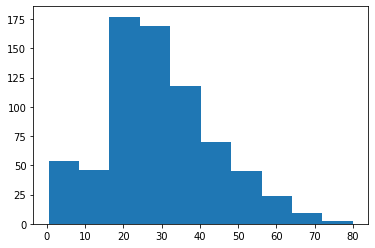

In [3]:
plt.hist(df['Age'])

In [4]:
#平均
df['Age'].mean()

29.69911764705882

In [5]:
#中央値
df['Age'].median()

28.0

In [6]:
#最頻値
df['Age'].mode()

0    24.0
dtype: float64

以上より，平均値も中央値もほぼ同じ値になったが最頻値のみ少し値が異なった．正直どの値が最も適切かはわからないのでとりあえず中央値で補完してみることにする．

In [20]:
df['Age'].fillna(df['Age'].median(),inplace=True)
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

fillnaの引数にinplaceをTrueにすることでdfの**Age**を中央値で補完することができた．

titanic号のデータ入力値の値の範囲は Age, Fare, Pclassといった指標ごとに大きく異なっており，単位も異なるため，各入力変数ごとに平均が 0，分散が 1 となるように値をスケーリングする**標準化** (standardization) を行うことで入力変数の**正規化**を行う．

まずは，入力変数（Pclass,Age,Fare）をxとして格納，その後にxを正規化していく．

In [21]:
from sklearn.preprocessing import StandardScaler
x = df[['Pclass','Age','Fare']]
t = df[['Survived']]
scaler = StandardScaler()
scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
x_scaled = scaler.transform(x)

以上のコードで標準化は行われたので結果を確認してみる．

In [23]:
scaler.fit(x_scaled)
#平均(0)
scaler.mean_

array([-8.77213254e-17,  2.27277979e-16,  3.98733297e-18])

In [24]:
#分散(1)
scaler.var_

array([1., 1., 1.])

# 3. 統計処理


scikit-learn で重回帰分析を行うためにLinearRegression クラスを使用する．

In [25]:
from sklearn.linear_model import LinearRegression

# モデルの定義
reg_model = LinearRegression()
# モデルの訓練
reg_model.fit(x_scaled, t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# 訓練後のパラメータ w
reg_model.coef_

array([[-0.1763947 , -0.09513991,  0.03740324]])

In [27]:
# 訓練後のバイアス b
reg_model.intercept_

array([0.38383838])

In [28]:
# 精度の検証
reg_model.score(x_scaled, t)

0.15525998436924082

驚くべきことにかなり少ない精度が検出されてしまった．理由として考えられるのは，Survivedは0か1であり，重回帰分析で予測するには値が中途半端になるためscoreも低くなってしまうのではないかと考えた．

とりあえずこれをtest.csvに適応して値を確認してみる．

In [29]:
df1 = pd.read_csv('test.csv')
x_test = df1[['Pclass','Age','Fare']]
reg_model.predict(x_test[:1])

array([[-3.13483529]])

test.csvの1つ目を予測したところ，-3.12483529と0から離れた値となっている．

# 4. 考察
重回帰分析を用いて**Survived**の値予測を行なったが，入力変数が**Pclass,Age,Fare**の3つだと精度に欠け，値が予測しづらいことがわかった．そこで，より**Survived**と相関が強そうな**Pclass**のみの場合と，**Pclass,Age**の2つの入力値の場合の単・重回帰分析の結果を以下に出力する．

In [34]:
# Pclassのみ
x_pclass = df[['Pclass']]
scaler = StandardScaler()
scaler.fit(x_pclass)
x_scaled = scaler.transform(x_pclass)

# モデルの訓練
reg_model.fit(x_scaled, t)
# 精度の検証
reg_model.score(x_scaled, t)

0.11456941170524182

In [35]:
# Pclass,Ageの2つの場合
x_2 = df[['Pclass','Age']]
scaler = StandardScaler()
scaler.fit(x_2)
x_scaled = scaler.transform(x_2)

# モデルの訓練
reg_model.fit(x_scaled, t)
# 精度の検証
reg_model.score(x_scaled, t)

0.15118509634493238

Pclassのみ，Pclass,Ageの2つの場合の両者で入力変数が3つだった時よりも精度が落ちていることがわかった．

入力変数---------------精度

Pclass-------------------0.11456941170524182

Pclass,Age------------0.15118509634493238

Pclass,Age,Fare----0.15525998436924082

# 5.結果
以上の結果から入力変数が3つの時が最も精度が高くなることがわかった．しかし，それでも依然として精度は低いので重回帰分析はtitanic号の分析に関して適切な方法ではなかったのかもしれないと考えた．